In [1]:
import pandas as pd
import numpy as np
import joblib
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset

pd.set_option('display.max_rows', 300)

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
torch.cuda.is_available(), torch.cuda.device_count()

(False, 0)

In [3]:
no_cuda = False
device = torch.device("cuda" if torch.cuda.is_available() and not no_cuda else "cpu") # defult setting
n_gpu = torch.cuda.device_count()
n_gpu

0

## EDA

### Import csv

In [4]:
# 1
data = pd.read_csv('training.csv')
item_feature = pd.read_csv('item_feature.csv')
test = pd.read_csv('test_kaggle.csv')

In [5]:
data

,user_id,item_id,context_feature_id
0,0,28366,2
1,0,16109,2
2,0,11500,3
3,0,20750,2
4,0,8759,2
...,...,...,...
970240,200152,30710,2
970241,200152,30710,2
970242,200152,12006,2
970243,200152,25030,2


In [6]:
test

,id,user_id,item_id,context_feature_id
0,0,4,16835,2
1,1,4,22590,3
2,2,4,1978,1
3,3,4,28916,1
4,4,4,14427,2
...,...,...,...,...
381380,381380,200151,1702,1
381381,381381,200151,21632,1
381382,381382,200151,30477,1
381383,381383,200151,30477,1


### Check data duplication

In [7]:
# delete duplicate
data = data[data.duplicated() == False]

In [8]:
data

,user_id,item_id,context_feature_id
0,0,28366,2
1,0,16109,2
2,0,11500,3
3,0,20750,2
4,0,8759,2
...,...,...,...
970239,200150,20387,2
970240,200152,30710,2
970242,200152,12006,2
970243,200152,25030,2


### Compare training and test data set coverage

In [9]:
(data.user_id.nunique(), test.user_id.nunique()), (data.item_id.nunique(), test.item_id.nunique())

((169698, 37893), (37978, 14586))

In [10]:
(data.user_id.min(), data.user_id.max()), (data.item_id.min(), data.item_id.max())

((0, 200152), (0, 39900))

In [11]:
(test.user_id.min(), test.user_id.max()), (test.item_id.min(), test.item_id.max())

((4, 200151), (3, 39899))

In [12]:
len(set(test.user_id.unique()).intersection(set(data.user_id.unique()))) / len(set(test.user_id.unique())) * 100
# 80% of test user_ids are new

19.628955216002954

In [13]:
len(set(test.item_id.unique()).intersection(set(data.item_id.unique()))) / len(set(test.item_id.unique())) * 100
# 14% of test user_ids are new

86.81612505141916

As so many new user and item, we decided not to encode training and test data

### Are users unique in specific context?

In [14]:
context_0_user = data[data["context_feature_id"] == 0].user_id.unique()
context_1_user = data[data["context_feature_id"] == 1].user_id.unique()
context_2_user = data[data["context_feature_id"] == 2].user_id.unique()
context_3_user = data[data["context_feature_id"] == 3].user_id.unique()

overlap_0_1 = len(set(context_0_user).intersection(set(context_1_user)))
overlap_0_2 = len(set(context_0_user).intersection(set(context_2_user)))
overlap_0_3 = len(set(context_0_user).intersection(set(context_3_user)))
overlap_1_2 = len(set(context_1_user).intersection(set(context_2_user)))
overlap_1_3 = len(set(context_1_user).intersection(set(context_3_user)))
overlap_2_3 = len(set(context_2_user).intersection(set(context_3_user)))

overlap_0 = overlap_0_1 + overlap_0_2 + overlap_0_3
overlap_1 = overlap_0_1 + overlap_1_2 + overlap_1_3
overlap_2 = overlap_0_2 + overlap_1_2 + overlap_2_3
overlap_3 = overlap_0_3 + overlap_1_3 + overlap_2_3

dict_overlap = {0:overlap_0, 1: overlap_1, 2: overlap_2, 3: overlap_3}

df_overlap = pd.DataFrame(data.context_feature_id.value_counts())
df_overlap.rename(columns={"context_feature_id": "unique_cout"}, inplace=True)
df_overlap['context_feature_id']= df_overlap.index
df_overlap['overlap'] = df_overlap['context_feature_id'].map(dict_overlap)
df_overlap['overlap_percent'] = df_overlap['overlap'] / df_overlap['unique_cout'] * 100
df_overlap.reset_index(inplace=True, drop=True)

In [15]:
df_overlap

,unique_cout,context_feature_id,overlap,overlap_percent
0,458127,2,130149,28.408935
1,227138,1,61696,27.162342
2,142446,3,109428,76.820690
3,64660,0,27951,43.227652


As shown above, many users are specific to only one context. So random sampling context_feature_id is not reasonable

### Merge item_feature to data, and check if users like one feature will not like other features

In [16]:
# 1. merge data
data = data.merge(item_feature, left_on='item_id', right_on='item_id', how='left')

In [17]:
# 2. check if users like one feature will not like other features
values = []
keys = []
for feature in data['item_feature_id'].unique():
    value = set(data[data['item_feature_id'] == feature].user_id.unique())
    values.append(value)
    keys.append(feature)
itemfeature_user_dict = dict(zip(keys, values))

import copy
itemfeature_user_overlap_percent = []
itemfeature = []
for key in itemfeature_user_dict:
    itemfeature_user_dict_copy = copy.deepcopy(itemfeature_user_dict)
    del itemfeature_user_dict_copy[key]
    a = set()
    for v_set in itemfeature_user_dict_copy.values():
        for v in v_set:
            a.add(v) # add all user ids in other features
    percent = len(itemfeature_user_dict[key].intersection(a)) / len(itemfeature_user_dict[key]) * 100
    itemfeature_user_overlap_percent.append(percent)
    itemfeature.append(key)
itemfeature_user_overlap_mapper = dict(zip(itemfeature, itemfeature_user_overlap_percent))

In [18]:
# 3. add overlap to dataframe
df_overlap_itemfeature = pd.DataFrame(data.item_feature_id.value_counts())
df_overlap_itemfeature.rename(columns={"item_feature_id": "unique_cout"}, inplace=True)
df_overlap_itemfeature['item_feature_id']= df_overlap_itemfeature.index
df_overlap_itemfeature['overlap'] = df_overlap_itemfeature['item_feature_id']\
.map(itemfeature_user_overlap_mapper)
df_overlap_itemfeature.reset_index(inplace=True, drop=True)

In [19]:
df_overlap_itemfeature.sort_values('overlap')

,unique_cout,item_feature_id,overlap
158,3,133,0.000000
21,10740,3,11.695685
7,29093,6,13.042855
16,15919,20,14.668874
0,110862,142,15.978653
18,13045,124,20.084467
29,4635,18,20.498915
19,11721,131,23.076923
17,15836,165,23.509934
36,3143,56,23.609227


In [20]:
df_overlap_itemfeature[df_overlap_itemfeature['overlap'] < 30]['unique_cout'].sum() / len(data)

0.30847371776985133

only 30% users like small user-overlap item features (overlap < 30%). So random sampling item features should be OK

### rating = 1

In [21]:
data['rating'] = 1

In [22]:
data

,user_id,item_id,context_feature_id,item_feature_id,rating
0,0,28366,2,7,1
1,0,16109,2,7,1
2,0,11500,3,7,1
3,0,20750,2,7,1
4,0,8759,2,7,1
...,...,...,...,...,...
892366,200150,20387,2,2,1
892367,200152,30710,2,148,1
892368,200152,12006,2,148,1
892369,200152,25030,2,148,1


## MF Model

### Negative Sampling

In [23]:
# 1. Popularity sampling
uniqs, counts = np.unique(data['item_id'], return_counts=True)
total_count = sum(counts)
item_probabilities = [0]*(data['item_id'].max()+1) # tweak
for item, count in zip(uniqs, counts):
    item_probabilities[item] = count / total_count
item_probabilities = np.array(item_probabilities)
item_list = np.array((range(data['item_id'].max()+1)))

item_prob_max = item_probabilities.max()
item_prob_min = item_probabilities[item_probabilities>0].min()
item_prob_1_4th = np.quantile(item_probabilities[item_probabilities > 0], 0.25)
item_prob_2_4th = np.quantile(item_probabilities[item_probabilities > 0], 0.5)
item_prob_3_4th = np.quantile(item_probabilities[item_probabilities > 0], 0.75)

item_nesample_num = [0] * len(item_probabilities)
for i, item_prob in enumerate(list(item_probabilities)):
    if item_prob < item_prob_min:
        item_nesample_num[i] = 0
    elif item_prob <= item_prob_1_4th:
        item_nesample_num[i] = 6
    elif item_prob <= item_prob_2_4th:
        item_nesample_num[i] = 5
    elif item_prob <= item_prob_3_4th:
        item_nesample_num[i] = 4
    else:
        item_nesample_num[i] = 2
item_nesample_mapper = dict(zip(item_list, item_nesample_num))

In [24]:
np.unique(np.array(item_nesample_num))

array([0, 2, 4, 5, 6])

(array([ 1923.,     0.,     0.,  9181.,     0.,     0.,  7373.,     0.,
         9329., 12095.]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <BarContainer object of 10 artists>)

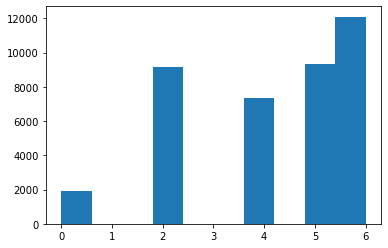

In [25]:
plt.hist(item_nesample_num)

In [26]:
# 2. Negetive sampling and create df
import random
item_item_feature_map = data[['item_id', 'item_feature_id']].set_index('item_id').to_dict()['item_feature_id']
data['rating'] = 1
df_ = data.set_index(['user_id', 'item_id', 'context_feature_id', 'item_feature_id'])
df_dict = df_['rating'].to_dict()
item_unique = list(set(data['item_id']))
users, items, context_features, item_features, ratings = [], [], [], [], []
for (u, i, c, f) in tqdm(df_dict.keys()):
    # positives
    users.append(u)
    items.append(i)
    context_features.append(c)
    item_features.append(f)
    ratings.append(1)
    # negatives
    num_negative = item_nesample_mapper[i]
    for _ in range(num_negative):
        j = random.choice(item_unique)
        
        while (u, j, c, f) in df_dict: #or item_item_feature_map[j] == f:
            j = random.choice(item_unique)
            
        users.append(u)
        items.append(j)
        context_features.append(c)
        item_features.append(f)
        ratings.append(0)
        
df = pd.DataFrame()
df['user'] = users
df['item'] = items
df['context_feature'] = context_features
df['item_feature'] = item_features
df['rating'] = ratings        

100%|██████████| 892371/892371 [00:02<00:00, 327940.97it/s]


In [27]:
df

,user,item,context_feature,item_feature,rating
0,0,28366,2,7,1
1,0,31012,2,7,0
2,0,17834,2,7,0
3,0,16109,2,7,1
4,0,30744,2,7,0
...,...,...,...,...,...
2872723,200152,27,2,148,0
2872724,200152,17077,2,148,0
2872725,200152,14578,2,148,1
2872726,200152,36498,2,148,0


### Model

In [28]:
class MF(nn.Module):
    def __init__(self, num_users, num_items, emb_size=100, seed=23):
        super(MF, self).__init__()
        torch.manual_seed(seed)
        self.user_emb = nn.Embedding(num_users+1, emb_size)
        self.user_bias = nn.Embedding(num_users+1, 1)
        self.item_emb = nn.Embedding(num_items+1, emb_size)
        self.item_bias = nn.Embedding(num_items+1, 1)
        
        # init 
        self.user_emb.weight.data.uniform_(0,0.05)
        self.item_emb.weight.data.uniform_(0,0.05)
        self.user_bias.weight.data.uniform_(-0.01,0.01)
        self.item_bias.weight.data.uniform_(-0.01,0.01)

    def forward(self, u, v):
        ### BEGIN SOLUTION
        U = self.user_emb(u)
        V = self.item_emb(v)
        b_u = self.user_bias(u).squeeze()
        b_v = self.item_bias(v).squeeze()
        logits = (U*V).sum(1) + b_u  + b_v
        return torch.sigmoid(logits)
        ### END SOLUTION

In [29]:
def train_one_epoch(model, train_df, optimizer, feature_flag=False):
    """ Trains the model for one epoch"""
    model.train()
    ### BEGIN SOLUTION
    users = torch.LongTensor(train_df['user'].values)  #.cuda()
    items = torch.LongTensor(train_df['item'].values) #.cuda()
    ratings = torch.FloatTensor(train_df['rating'].values)  #.cuda()

    if feature_flag == True:
        item_feature = torch.LongTensor(train_df['item_feature'].values) #.cuda()
        context_feature = torch.LongTensor(train_df['context_feature'].values) #.cuda()
        y_hat = model(users, items, item_feature, context_feature)
    else:
        y_hat = model(users, items)
    loss = F.binary_cross_entropy(y_hat, ratings)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_loss = loss.item()
    ### END SOLUTION
    return train_loss

In [30]:
def training(model, train_df, epochs=10, lr=0.01, wd=0.0, feature_flag=False):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    for i in range(epochs):
        train_loss = train_one_epoch(model, train_df, optimizer, feature_flag)
        print("train loss %.3f" % (train_loss))

In [29]:
item_max = df['item'].max()
user_max = df['user'].max()
model = MF(user_max, item_max, emb_size=50) 
training(model, df, epochs=35, lr=0.1, wd=1e-6)

train loss 0.699
train loss 0.734
train loss 0.593
train loss 0.546
train loss 0.504
train loss 0.431
train loss 0.363
train loss 0.320
train loss 0.299
train loss 0.286
train loss 0.276
train loss 0.270
train loss 0.264
train loss 0.257
train loss 0.248
train loss 0.239
train loss 0.229
train loss 0.222
train loss 0.216
train loss 0.211
train loss 0.208
train loss 0.206
train loss 0.203
train loss 0.201
train loss 0.198
train loss 0.194
train loss 0.191
train loss 0.186
train loss 0.182
train loss 0.178
train loss 0.174
train loss 0.171
train loss 0.169
train loss 0.167
train loss 0.166


### Predict

In [30]:
users = torch.LongTensor(test['user_id'].values)  #.cuda()
items = torch.LongTensor(test['item_id'].values) #.cuda()
#item_features = torch.LongTensor(test['item_feature_id'].values) #.cuda()
context_features = torch.LongTensor(test['context_feature_id'].values) #.cuda()

In [31]:
y_pred = model(users, items).detach().numpy()
test['rating']= y_pred

In [32]:
test

,id,user_id,item_id,context_feature_id,rating
0,0,4,16835,2,0.391639
1,1,4,22590,3,0.347531
2,2,4,1978,1,0.833119
3,3,4,28916,1,0.173881
4,4,4,14427,2,0.164574
...,...,...,...,...,...
381380,381380,200151,1702,1,0.785238
381381,381381,200151,21632,1,0.861450
381382,381382,200151,30477,1,0.822168
381383,381383,200151,30477,1,0.822168


In [33]:
np.mean(y_pred)

0.5195259

In [34]:
ypred_hard= np.where(y_pred >= 0.5, 1, 0)
sum(ypred_hard == 1) / len(ypred_hard)

0.485380914299199

In [35]:
test[['id', 'rating']].to_csv("predict.csv", index=False)

### Save embeddings and bias

In [36]:
user_embeddings = model.user_emb.weight.detach()
item_embeddings = model.item_emb.weight.detach()
user_bias = model.user_bias.weight.detach()
item_bias = model.item_bias.weight.detach()

In [37]:
user_embeddings.shape, item_embeddings.shape, user_bias.shape, item_bias.shape

(torch.Size([200153, 50]),
 torch.Size([39901, 50]),
 torch.Size([200153, 1]),
 torch.Size([39901, 1]))

## Cross validation

### Model

In [38]:
def valid_metrics(model, users_val, items_val, ratings_val):
    """Computes validation loss and accuracy"""
    model.eval()
    ### BEGIN SOLUTION
    y_hat = model(users_val, items_val)
    loss = F.binary_cross_entropy(y_hat, ratings_val)
    valid_loss = loss.item()

    # Accuracy
    y = ratings_val.detach().tolist()
    ypred = y_hat.detach().tolist()

    ### END SOLUTION
    return ypred, y, valid_loss

In [39]:
def train_one_epoch(model, df, optimizer, cv_n_split=10, cv_random_state=1, cv_shuffle=True):
    """ Trains the model for one epoch"""
    ### BEGIN SOLUTION
    kf = KFold(n_splits=cv_n_split, random_state=cv_random_state, shuffle=cv_shuffle)
    pred = []
    ys = []
    valid_loss_list = []
    model.train()
    for fold, (train_ids, val_ids) in enumerate(kf.split(df)):
        users_train = torch.LongTensor(df['user'][train_ids].values)  #.cuda()
        users_val = torch.LongTensor(df['user'][val_ids].values)  #.cuda()
        items_train = torch.LongTensor(df['item'][train_ids].values) #.cuda()
        items_val = torch.LongTensor(df['item'][val_ids].values)  #.cuda()
        ratings_train = torch.FloatTensor(df['rating'][train_ids].values)  #.cuda()
        ratings_val = torch.FloatTensor(df['rating'][val_ids].values)  #.cuda()
        
        y_train_hat = model(users_train, items_train)
        loss = F.binary_cross_entropy(y_train_hat, ratings_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss = loss.item()
        y_val_hat, y_val_true, valid_loss = valid_metrics(model, users_val, items_val, ratings_val)
        
        pred += y_val_hat
        ys += y_val_true
        valid_loss_list.append(valid_loss)
        print(f"FOLD: {fold+1} train loss {train_loss:.3f}")
    
    valid_loss_mean = np.array(valid_loss_list).mean()
    ypred_hard = np.where(np.array(pred) >= 0.5, 1, 0)
    valid_acc = np.sum(np.array(ys) == ypred_hard) / len(df)
    ### END SOLUTION
    return valid_loss_mean, valid_acc

In [40]:
def training(model, df, epochs=10, lr=0.01, wd=0.0, cv_n_split=10, cv_random_state=1, cv_shuffle=True):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    for i in range(epochs):
        valid_loss, valid_acc = train_one_epoch(model, df, optimizer, 
                                                cv_n_split=cv_n_split, 
                                                cv_random_state=cv_random_state, 
                                                cv_shuffle=cv_shuffle)
        print(f"Epoch: {i+1} valid_loss {valid_loss:.3f} valid_acc {valid_acc:.3f}")

In [41]:
item_max = df['item'].max()
user_max = df['user'].max()
model = MF(user_max, item_max, emb_size=50) 
training(model, df, epochs=10, lr=0.1, wd=1e-6, cv_n_split=5, cv_random_state=1, cv_shuffle=True)

FOLD: 1 train loss 0.699
FOLD: 2 train loss 0.732
FOLD: 3 train loss 0.593
FOLD: 4 train loss 0.547
FOLD: 5 train loss 0.503
Epoch: 1 valid_loss 0.562 valid_acc 0.771
FOLD: 1 train loss 0.429
FOLD: 2 train loss 0.362
FOLD: 3 train loss 0.320
FOLD: 4 train loss 0.300
FOLD: 5 train loss 0.288
Epoch: 2 valid_loss 0.311 valid_acc 0.893
FOLD: 1 train loss 0.279
FOLD: 2 train loss 0.274
FOLD: 3 train loss 0.269
FOLD: 4 train loss 0.263
FOLD: 5 train loss 0.255
Epoch: 3 valid_loss 0.260 valid_acc 0.916
FOLD: 1 train loss 0.246
FOLD: 2 train loss 0.236
FOLD: 3 train loss 0.228
FOLD: 4 train loss 0.221
FOLD: 5 train loss 0.216
Epoch: 4 valid_loss 0.221 valid_acc 0.942
FOLD: 1 train loss 0.211
FOLD: 2 train loss 0.208
FOLD: 3 train loss 0.206
FOLD: 4 train loss 0.203
FOLD: 5 train loss 0.200
Epoch: 5 valid_loss 0.202 valid_acc 0.960
FOLD: 1 train loss 0.196
FOLD: 2 train loss 0.192
FOLD: 3 train loss 0.188
FOLD: 4 train loss 0.184
FOLD: 5 train loss 0.180
Epoch: 6 valid_loss 0.183 valid_acc 0.96

### Try fewer epochs

In [42]:
item_max = df['item'].max()
user_max = df['user'].max()
model = MF(user_max, item_max, emb_size=50) 
training(model, df, epochs=7, lr=0.1, wd=1e-6, cv_n_split=5, cv_random_state=1, cv_shuffle=True)

FOLD: 1 train loss 0.699
FOLD: 2 train loss 0.732
FOLD: 3 train loss 0.593
FOLD: 4 train loss 0.547
FOLD: 5 train loss 0.503
Epoch: 1 valid_loss 0.562 valid_acc 0.771
FOLD: 1 train loss 0.429
FOLD: 2 train loss 0.362
FOLD: 3 train loss 0.320
FOLD: 4 train loss 0.300
FOLD: 5 train loss 0.288
Epoch: 2 valid_loss 0.311 valid_acc 0.893
FOLD: 1 train loss 0.279
FOLD: 2 train loss 0.274
FOLD: 3 train loss 0.269
FOLD: 4 train loss 0.263
FOLD: 5 train loss 0.255
Epoch: 3 valid_loss 0.260 valid_acc 0.916
FOLD: 1 train loss 0.246
FOLD: 2 train loss 0.236
FOLD: 3 train loss 0.228
FOLD: 4 train loss 0.221
FOLD: 5 train loss 0.216
Epoch: 4 valid_loss 0.221 valid_acc 0.942
FOLD: 1 train loss 0.211
FOLD: 2 train loss 0.208
FOLD: 3 train loss 0.206
FOLD: 4 train loss 0.203
FOLD: 5 train loss 0.200
Epoch: 5 valid_loss 0.202 valid_acc 0.960
FOLD: 1 train loss 0.196
FOLD: 2 train loss 0.192
FOLD: 3 train loss 0.188
FOLD: 4 train loss 0.184
FOLD: 5 train loss 0.180
Epoch: 6 valid_loss 0.183 valid_acc 0.96

### Predict

In [43]:
item_feature = pd.read_csv('data/item_feature.csv')

In [44]:
users = torch.LongTensor(test['user_id'].values)  #.cuda()
items = torch.LongTensor(test['item_id'].values) #.cuda()

y_pred = model(users, items).detach().numpy()
test['rating']= y_pred

print(np.mean(y_pred))
ypred_hard= np.where(y_pred >= 0.5, 1, 0)
print(sum(ypred_hard == 1) / len(ypred_hard))

0.520993
0.487066874680441


In [45]:
test[['id', 'rating']].to_csv("predict_2.csv", index=False)

Cross validation is no better than the previous result. If do trainning on the entire dataset, the best epoch should be35-40 to gain better result when embedding size is 50

## MF on features

### Model

In [31]:
item_feature = pd.read_csv('data/item_feature.csv')
test = pd.read_csv('data/test_kaggle.csv')
test = test.merge(item_feature, left_on='item_id', right_on='item_id', how='left')
test.rename(columns={"item_feature_id": "item_feature"}, inplace=True)

In [32]:
class MF_feature(nn.Module):
    def __init__(self, num_context, num_item_feature, emb_size=10, seed=23):
        super(MF_feature, self).__init__()
        torch.manual_seed(seed)
        self.context_emb = nn.Embedding(num_context+1, emb_size)
        self.context_bias = nn.Embedding(num_context+1, 1)
        self.item_feature_emb = nn.Embedding(num_item_feature+1, emb_size)
        self.item_feature_bias = nn.Embedding(num_item_feature+1, 1)
        
        # init 
        self.context_emb.weight.data.uniform_(0,0.05)
        self.item_feature_emb.weight.data.uniform_(0,0.05)
        self.context_bias.weight.data.uniform_(-0.01,0.01)
        self.item_feature_bias.weight.data.uniform_(-0.01,0.01)

    def forward(self, c, f):
        ### BEGIN SOLUTION
        C = self.context_emb(c)
        F = self.item_feature_emb(f)
        b_c = self.context_bias(c).squeeze()
        b_f = self.item_feature_bias(f).squeeze()
        logits = (C*F).sum(1) + b_c  + b_f
        return torch.sigmoid(logits)
        ### END SOLUTION

In [33]:
def train_one_epoch_feature(model, df, optimizer):
    """ Trains the model for one epoch"""
    model.train()
    ### BEGIN SOLUTION
    context_features = torch.LongTensor(df['context_feature'].values)  #.cuda()
    item_features = torch.LongTensor(df['item_feature'].values) #.cuda()
    ratings = torch.FloatTensor(df['rating'].values)  #.cuda()
    
    y_hat = model(context_features, item_features)
    loss = F.binary_cross_entropy(y_hat, ratings)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_loss = loss.item()
    ### END SOLUTION
    return train_loss

In [34]:
def training_feature(model, df, epochs=10, lr=0.01, wd=0.0, feature_flag=False):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    for i in range(epochs):
        train_loss = train_one_epoch_feature(model, df, optimizer)
        print("train loss %.3f" % (train_loss))

In [50]:
context_feature_max = df['context_feature'].max()
item_feature_max = df['item_feature'].max()
model_feature = MF_feature(context_feature_max, item_feature_max, emb_size=10) 
training_feature(model_feature, df, epochs=20, lr=0.01)

train loss 0.694
train loss 0.689
train loss 0.685
train loss 0.682
train loss 0.679
train loss 0.675
train loss 0.672
train loss 0.669
train loss 0.665
train loss 0.662
train loss 0.659
train loss 0.656
train loss 0.652
train loss 0.649
train loss 0.646
train loss 0.643
train loss 0.640
train loss 0.637
train loss 0.634
train loss 0.631


### Save embeddings and bias

In [51]:
context_embeddings = model_feature.context_emb.weight.detach()
item_feature_embeddings = model_feature.item_feature_emb.weight.detach()
context_bias = model_feature.context_bias.weight.detach()
item_feature_bias = model_feature.item_feature_bias.weight.detach()

In [52]:
context_embeddings.size(), item_feature_embeddings.size(), context_bias.size(), item_feature_bias.size()

(torch.Size([4, 10]),
 torch.Size([195, 10]),
 torch.Size([4, 1]),
 torch.Size([195, 1]))

## NN model with extracted trained embedding (MF users+item, MF features)

### Get vector

In [53]:
user_vector = user_embeddings[df['user']]
item_vector = item_embeddings[df['item']]
context_vector = context_embeddings[df['context_feature']]
item_feature_vector = item_feature_embeddings[df['item_feature']]

In [54]:
user_vector.shape, item_vector.shape, context_vector.shape, item_feature_vector.shape

(torch.Size([2872728, 50]),
 torch.Size([2872728, 50]),
 torch.Size([2872728, 10]),
 torch.Size([2872728, 10]))

In [55]:
concat_vector = torch.cat([user_vector, item_vector, context_vector, item_feature_vector], 1)

In [56]:
concat_vector

tensor([[-0.2829,  0.0020, -0.0806,  ...,  0.1501,  0.1136, -0.1244],
        [-0.2829,  0.0020, -0.0806,  ...,  0.1501,  0.1136, -0.1244],
        [-0.2829,  0.0020, -0.0806,  ...,  0.1501,  0.1136, -0.1244],
        ...,
        [-0.0188,  0.1603, -0.0535,  ...,  0.1520,  0.1103, -0.1201],
        [-0.0188,  0.1603, -0.0535,  ...,  0.1520,  0.1103, -0.1201],
        [-0.0188,  0.1603, -0.0535,  ...,  0.1520,  0.1103, -0.1201]])

### Model

In [57]:
model_nn = nn.Sequential(
    nn.Linear(120, 60), 
    nn.Dropout(0.1),
    nn.ReLU(),
    nn.Linear(60, 30),
    nn.Dropout(0.1),
    nn.ReLU(),
    nn.Linear(30, 15),
    nn.ReLU(),
    nn.Linear(15, 1),
    nn.Sigmoid()
    )

In [58]:
def train_one_epoch_nn(model, df, concat_vector, optimizer):
    """ Trains the model for one epoch"""
    model.train()
    ### BEGIN SOLUTION
    ratings = torch.FloatTensor(df['rating'].values).unsqueeze(1)  #.cuda()
    
    y_hat = model(concat_vector)
    loss = F.binary_cross_entropy(y_hat, ratings)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_loss = loss.item()
    ### END SOLUTION
    return train_loss

In [59]:
def training_nn(model, df, concat_vector, epochs=10, lr=0.01, wd=0.0):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    for i in range(epochs):
        train_loss = train_one_epoch_nn(model, df, concat_vector, optimizer)
        print("train loss %.3f" % (train_loss))

In [60]:
model_nn = nn.Sequential(
    nn.Linear(120, 60), 
    nn.Dropout(0.1),
    nn.ReLU(),
    nn.Linear(60, 30),
    nn.Dropout(0.1),
    nn.ReLU(),
    nn.Linear(30, 15),
    nn.ReLU(),
    nn.Linear(15, 1),
    nn.Sigmoid()
    )

training_nn(model_nn, df, concat_vector, epochs=30, lr=0.01)

train loss 0.714
train loss 0.693
train loss 0.668
train loss 0.636
train loss 0.606
train loss 0.585
train loss 0.574
train loss 0.561
train loss 0.540
train loss 0.512
train loss 0.479
train loss 0.445
train loss 0.419
train loss 0.407
train loss 0.406
train loss 0.412
train loss 0.420
train loss 0.422
train loss 0.414
train loss 0.402
train loss 0.388
train loss 0.378
train loss 0.375
train loss 0.377
train loss 0.378
train loss 0.375
train loss 0.369
train loss 0.362
train loss 0.353
train loss 0.346


### Predict (get embedding for test first)

In [61]:
test_user_vector = user_embeddings[test['user_id']]
test_item_vector = item_embeddings[test['item_id']]
test_context_vector = context_embeddings[test['context_feature_id']]
test_item_feature_vector = item_feature_embeddings[test['item_feature']]
test_concat_vector = torch.cat([test_user_vector, test_item_vector, 
                                test_context_vector, test_item_feature_vector], 1)

In [62]:
y_pred = model_nn(test_concat_vector).detach().numpy()
test['rating']= y_pred

print(np.mean(y_pred))
ypred_hard= np.where(y_pred >= 0.5, 1, 0)
print(sum(ypred_hard == 1) / len(ypred_hard))

0.46583182
[0.38084875]


## NN model added in MF

In [63]:
class MF_nn(nn.Module):
    def __init__(self, num_users, num_items, emb_size=50, seed=23):
        super(MF_nn, self).__init__()
        torch.manual_seed(seed)
        self.user_emb = nn.Embedding(num_users+1, emb_size)
        self.user_bias = nn.Embedding(num_users+1, 1)
        self.item_emb = nn.Embedding(num_items+1, emb_size)
        self.item_bias = nn.Embedding(num_items+1, 1)
        self.linear1 = nn.Linear(100, 50)
        self.linear2 = nn.Linear(50, 25)
        self.linear3 = nn.Linear(25, 1)
        
        # init 
        self.user_emb.weight.data.uniform_(0,0.05)
        self.item_emb.weight.data.uniform_(0,0.05)

    def forward(self, u, v):
        ### BEGIN SOLUTION
        U = self.user_emb(u)
        V = self.item_emb(v)
        
        x = torch.cat([U, V], 1)
        x = self.linear1(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.1)
        x = self.linear2(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.1)
        x = self.linear3(x)
        
        return torch.sigmoid(x)
        ### END SOLUTION

In [64]:
def train_one_epoch_mf_nn(model, train_df, optimizer):
    """ Trains the model for one epoch"""
    model.train()
    ### BEGIN SOLUTION
    users = torch.LongTensor(train_df['user'].values)  #.cuda()
    items = torch.LongTensor(train_df['item'].values) #.cuda()
    ratings = torch.FloatTensor(train_df['rating'].values).unsqueeze(1)  #.cuda()

    y_hat = model(users, items)
    loss = F.binary_cross_entropy(y_hat, ratings)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_loss = loss.item()
    ### END SOLUTION
    return train_loss

In [65]:
def training_mf_nn(model, train_df, epochs=10, lr=0.01, wd=0.0):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    for i in range(epochs):
        train_loss = train_one_epoch_mf_nn(model, train_df, optimizer)
        print("train loss %.3f" % (train_loss))

In [66]:
item_max = df['item'].max()
user_max = df['user'].max()
model_mf_nn = MF_nn(user_max, item_max, emb_size=50) 
training_mf_nn(model_mf_nn, df, epochs=35, lr=0.1, wd=1e-6)

train loss 0.698
train loss 0.613
train loss 1.889
train loss 0.391
train loss 0.668
train loss 0.504
train loss 0.361
train loss 0.368
train loss 0.366
train loss 0.326
train loss 0.335
train loss 0.356
train loss 0.329
train loss 0.303
train loss 0.314
train loss 0.305
train loss 0.292
train loss 0.291
train loss 0.301
train loss 0.300
train loss 0.288
train loss 0.289
train loss 0.303
train loss 0.286
train loss 0.295
train loss 0.281
train loss 0.291
train loss 0.272
train loss 0.271
train loss 0.268
train loss 0.263
train loss 0.260
train loss 0.257
train loss 0.252
train loss 0.246


In [67]:
users = torch.LongTensor(test['user_id'].values)
items = torch.LongTensor(test['item_id'].values)

y_pred = model_mf_nn(users, items).detach().numpy()
test['rating']= y_pred
print(np.mean(y_pred))
ypred_hard= np.where(y_pred >= 0.5, 1, 0)
print(sum(ypred_hard == 1) / len(ypred_hard))

0.47756058
[0.47095193]


In [68]:
test[['id', 'rating']].to_csv("predict_nn.csv", index=False)

## Random Forest with extracted trained embedding, and two features

### Fit model

In [69]:
def train_one_epoch(model, train_df, optimizer, feature_flag=False):
    """ Trains the model for one epoch"""
    model.train()
    ### BEGIN SOLUTION
    users = torch.LongTensor(train_df['user'].values)  #.cuda()
    items = torch.LongTensor(train_df['item'].values) #.cuda()
    ratings = torch.FloatTensor(train_df['rating'].values)  #.cuda()

    if feature_flag == True:
        item_feature = torch.LongTensor(train_df['item_feature'].values) #.cuda()
        context_feature = torch.LongTensor(train_df['context_feature'].values) #.cuda()
        y_hat = model(users, items, item_feature, context_feature)
    else:
        y_hat = model(users, items)
    loss = F.binary_cross_entropy(y_hat, ratings)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_loss = loss.item()
    ### END SOLUTION
    return train_loss

def training(model, train_df, epochs=10, lr=0.01, wd=0.0, feature_flag=False):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    for i in range(epochs):
        train_loss = train_one_epoch(model, train_df, optimizer, feature_flag)
        print("train loss %.3f" % (train_loss))

In [70]:
item_max = df['item'].max()
user_max = df['user'].max()
model = MF(user_max, item_max, emb_size=10) 
training(model, df, epochs=35, lr=0.1, wd=1e-6)

train loss 0.694
train loss 0.657
train loss 0.593
train loss 0.552
train loss 0.515
train loss 0.475
train loss 0.435
train loss 0.396
train loss 0.361
train loss 0.330
train loss 0.306
train loss 0.290
train loss 0.279
train loss 0.272
train loss 0.268
train loss 0.266
train loss 0.265
train loss 0.263
train loss 0.259
train loss 0.253
train loss 0.246
train loss 0.239
train loss 0.232
train loss 0.226
train loss 0.221
train loss 0.217
train loss 0.213
train loss 0.210
train loss 0.207
train loss 0.204
train loss 0.200
train loss 0.197
train loss 0.194
train loss 0.191
train loss 0.189


In [71]:
item_embeddings = model.item_emb.weight.detach().numpy()
user_embeddings = model.user_emb.weight.detach().numpy()
train_user_embeddings = pd.DataFrame(user_embeddings[df['user'].values], 
                                     columns= [f'ue_{i}' for i in range(user_embeddings.shape[1])])
train_item_embeddings = pd.DataFrame(item_embeddings[df['item'].values], 
                                     columns= [f'ie_{i}' for i in range(user_embeddings.shape[1])])
train = pd.concat((df['context_feature'], df['item_feature'],
                   train_user_embeddings, train_item_embeddings), axis=1)

In [72]:
train.head(2).T

,0,1
context_feature,2.000000,2.000000
item_feature,7.000000,7.000000
ue_0,0.301027,0.301027
ue_1,-0.247001,-0.247001
ue_2,-0.066983,-0.066983
ue_3,-0.580410,-0.580410
ue_4,-0.605586,-0.605586
ue_5,-0.441356,-0.441356
ue_6,-0.335058,-0.335058
ue_7,-0.422628,-0.422628


In [73]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_jobs=-1)
rf.fit(train, df['rating'])

RandomForestClassifier(n_jobs=-1)

### Predict

In [74]:
test_user_embeddings = pd.DataFrame(user_embeddings[test['user_id'].values], 
                                    columns= [f'ue_{i}' for i in range(user_embeddings.shape[1])])
test_item_embeddings = pd.DataFrame(item_embeddings[test['item_id'].values], 
                                    columns= [f'ie_{i}' for i in range(user_embeddings.shape[1])])
test_df = pd.concat((test['context_feature_id'], test['item_feature'], 
                     test_user_embeddings, test_item_embeddings), axis=1)
test_df.rename(columns={"context_feature_id": "context_feature"}, inplace=True)

In [75]:
y_pred = rf.predict(test_df)
test['rating']= y_pred

print(np.mean(y_pred))
ypred_hard= np.where(y_pred >= 0.5, 1, 0)
print(sum(ypred_hard == 1) / len(ypred_hard))

0.4060962020006031
0.4060962020006031


In [76]:
test[['id', 'rating']].to_csv("predict_rf.csv", index=False)

## Neural Network with Extra Features (Data Loader)

In [38]:
from torch.utils.data import Dataset, DataLoader
class NNDataset(Dataset):
    def __init__(self, df):
        self.user = df['user'].values
        self.item = df['item'].values
        self.item_feature = df['item_feature'].values
        self.context_feature = df['context_feature'].values
        self.rating = df['rating'].values
    
    def __len__(self):
        return len(self.user)

    def __getitem__(self, index):
        user_id = self.user[index]
        item_id = self.item[index]
        item_feature = self.item_feature[index]
        context_feature = self.context_feature[index]
        rating = self.rating[index]
        return {"user_id": user_id,
                "item_id": item_id, 
                "item_feature": item_feature,
                "context_feature": context_feature,
                "rating": rating}

In [39]:
data_ds = NNDataset(df)
data_dl = DataLoader(data_ds, batch_size=50000, shuffle=True)

In [40]:
class MLP(nn.Module):
    def __init__(self, n_users, n_items, n_item_features, n_context_features, 
                layers=[200, 100],
                dropout=0.8):
        super().__init__()
        self.dropout = dropout
        self.embedding_dim = int(layers[0] * 3/8)
        self.item_feature_embedding_dim = int(layers[0] * 1/5)
        self.context_feature_embedding_dim = int(layers[0] * 1/20)

        # user and item embedding layers
        self.user_embedding = nn.Embedding(n_users+1, self.embedding_dim)
        self.item_embedding = nn.Embedding(n_items+1, self.embedding_dim)
        self.item_feature_embedding = nn.Embedding(n_item_features+1, self.item_feature_embedding_dim)
        self.context_feature_embedding = nn.Embedding(n_context_features+1, self.context_feature_embedding_dim)        

        # init 
        self.user_embedding.weight.data.uniform_(0,0.05)
        self.item_embedding.weight.data.uniform_(0,0.05)
        self.item_feature_embedding.weight.data.uniform_(0,0.05)
        self.context_feature_embedding.weight.data.uniform_(0,0.05)        

        self.fc_layers = torch.nn.ModuleList()
        # hidden dense layers
        for _, (in_size, out_size) in enumerate(zip(layers[:-1], layers[1:])):
            self.fc_layers.append(torch.nn.Linear(in_size, out_size))
        # final prediction layer
        self.output_layer = torch.nn.Linear(layers[-1], 1)

    def forward(self, feed_dict):
        users = feed_dict['user_id']
        items = feed_dict['item_id']
        item_features = feed_dict['item_feature']
        context_features = feed_dict['context_feature']

        user_embedding = self.user_embedding(users)
        item_embedding = self.item_embedding(items)
        item_feature_embedding = self.item_feature_embedding(item_features)
        context_feature_embedding = self.context_feature_embedding(context_features)    

        # concatenate user and item embeddings to form input
        x = torch.cat([user_embedding, item_embedding, 
                       item_feature_embedding, context_feature_embedding], 1)
        for idx, _ in enumerate(range(len(self.fc_layers))):
            x = self.fc_layers[idx](x)
            x = F.relu(x)
            x = F.dropout(x,  p=self.dropout, training=self.training)
        logit = self.output_layer(x)
        out = torch.sigmoid(logit)
        return out

In [41]:
def val_metric(model, data_loader):
    losses = []
    y_hats = []
    ys = []
    model.eval()
    for feed_dict in data_loader:
        prediction = model(feed_dict)
        rating = feed_dict['rating'] 
        rating = rating.float().view(prediction.size()) 
        loss = F.binary_cross_entropy(prediction, rating)
        y_hats.append(prediction.detach().numpy())
        ys.append(rating.numpy())
        losses.append(loss.item())
    ys = np.concatenate(ys)
    y_hats = np.concatenate(y_hats)
    ypred_hard = np.where(y_hats > 0.5, 1, 0)
    valid_acc = np.sum(ys == ypred_hard) / len(ys)    
    return np.mean(losses), valid_acc

In [42]:
def train_one_epoch(model, data_loader, optimizer):
    epoch_loss = []
    model.train()
    for feed_dict in data_loader:
        prediction = model(feed_dict)
        rating = feed_dict['rating']        
        # convert to float and change dim from [batch_size] to [batch_size,1]
        rating = rating.float().view(prediction.size())  
        loss = F.binary_cross_entropy(prediction, rating)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss.append(loss.item())
    epoch_loss = np.mean(epoch_loss)
    return epoch_loss

In [43]:
def train_nn(model, train_dl, epochs=10, lr=0.01, wd=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    for i in range(epochs):
        train_loss = train_one_epoch(model, train_dl, optimizer)
        # valid_loss, valid_acc = val_metric(model, valid_dl)
        print(f"train loss {train_loss:.3f}")

In [166]:
item_max = df['item'].max()
user_max = df['user'].max()
context_feature_max = df['context_feature'].max()
item_feature_max = df['item_feature'].max()
mlp = MLP(user_max, item_max, item_feature_max, context_feature_max)

In [167]:
train_nn(mlp, data_dl)

train loss 0.443
train loss 0.372
train loss 0.358
train loss 0.347
train loss 0.340
train loss 0.334
train loss 0.331
train loss 0.328
train loss 0.328
train loss 0.327


In [191]:
train_nn(mlp, data_dl, epochs=1, lr=0.001)

train loss 0.309


In [192]:
# Calculate mean embedding for the unknown users
with torch.no_grad():
    user_unique = df['user'].unique()
    user_n = len(user_unique)
    sum_embeddings = torch.zeros(mlp.user_embedding.weight.shape[1])
    for user in user_unique:
        sum_embeddings += mlp.user_embedding.weight[user]
    mlp.user_embedding.weight[user_max] = sum_embeddings / user_n

with torch.no_grad():
    item_unique = df['item'].unique()
    item_n = len(item_unique)
    sum_embeddings = torch.zeros(mlp.item_embedding.weight.shape[1])
    for item in item_unique:
        sum_embeddings += mlp.item_embedding.weight[item]
    mlp.item_embedding.weight[item_max] = sum_embeddings / item_n

In [193]:
test_mod = test.copy()
test_mod.loc[~test_mod['user_id'].isin(df['user']), 'user_id'] = user_max
test_mod.loc[~test_mod['item_id'].isin(df['item']), 'item_id'] = item_max

users = torch.LongTensor(test_mod['user_id'].values)
items = torch.LongTensor(test_mod['item_id'].values)
item_features = torch.LongTensor(test_mod['item_feature'].values)
context_features = torch.LongTensor(test_mod['context_feature_id'].values)

test_input = {
    "user_id": users,
    "item_id": items,
    "item_feature": item_features,
    "context_feature": context_features,
}

mlp.eval()
y_pred = mlp(test_input).detach().numpy()
test['rating']= y_pred
print(np.mean(y_pred))
ypred_hard= np.where(y_pred >= 0.5, 1, 0)
print(sum(ypred_hard == 1) / len(ypred_hard))

0.49968666
[0.49246824]


In [194]:
test[['id', 'rating']].to_csv("DL_Master_Submission.csv", index=False)

## Another Neural Network with Extra Features (TensorDataset)

In [55]:
# Split x and y and put into tersor dataset, and dataloader
user_tensor = torch.LongTensor(df['user'].values)
item_tensor = torch.LongTensor(df['item'].values)
context_feature_tensor = torch.LongTensor(df['context_feature'].values)
item_feature_tensor = torch.LongTensor(df['item_feature'].values)
rating_tensor = torch.FloatTensor(df['rating'].values)

train_data = TensorDataset(user_tensor, item_tensor, context_feature_tensor,
                          item_feature_tensor, rating_tensor)
train_dl = DataLoader(train_data, batch_size=500000, shuffle=True)

In [56]:
dataset_iter = iter(train_dl)
first = next(dataset_iter)

In [57]:
first

[tensor([ 15730,  52897, 124460,  ...,  13427, 173838, 106574]),
 tensor([10984,  6366, 22793,  ..., 15479, 30550, 11530]),
 tensor([1, 1, 1,  ..., 2, 2, 3]),
 tensor([174,  55, 148,  ..., 139,  68, 153]),
 tensor([0., 0., 1.,  ..., 0., 1., 0.])]

In [58]:
class MF_nn(nn.Module):
    def __init__(self, num_users, num_items, num_context_feature, 
                 num_item_feature, emb_size=40, 
                 emb_size_context_feature=5, emb_size_item_feature=10, seed=23):
        super(MF_nn, self).__init__()
        torch.manual_seed(seed)
        self.user_emb = nn.Embedding(num_users+1, emb_size)
        self.user_bias = nn.Embedding(num_users+1, 1)
        self.item_emb = nn.Embedding(num_items+1, emb_size)
        self.item_bias = nn.Embedding(num_items+1, 1)
        
        self.context_feature_emb = nn.Embedding(num_context_feature+1, emb_size_context_feature)
        self.context_feature_bias = nn.Embedding(num_context_feature+1, 1)
        self.item_feature_emb = nn.Embedding(num_item_feature+1, emb_size_item_feature)
        self.item_feature_bias = nn.Embedding(num_item_feature+1, 1)
        
        self.linear1 = nn.Linear(95, 50)
        self.linear2 = nn.Linear(50, 25)
        self.linear3 = nn.Linear(25, 1)
        
        # init 
        self.user_emb.weight.data.uniform_(0,0.05)
        self.item_emb.weight.data.uniform_(0,0.05)
        self.context_feature_emb.weight.data.uniform_(0,0.05)
        self.item_feature_emb.weight.data.uniform_(0,0.05)        

    def forward(self, u, v, cf, vf):
        ### BEGIN SOLUTION
        U = self.user_emb(u)
        V = self.item_emb(v)
        CF = self.context_feature_emb(cf)
        VF = self.item_feature_emb(vf)
        
        x = torch.cat([U, V, CF, VF], 1)
        x = self.linear1(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.6)
        x = self.linear2(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.6)
        x = self.linear3(x)
        
        return torch.sigmoid(x)
        ### END SOLUTION

In [59]:
def train_one_epoch_mf_nn(model, train_dl, optimizer):
    """ Trains the model for one epoch"""
    epoch_loss = []
    model.to(device)
#    if n_gpu > 1:
#        model = torch.nn.DataParallel(model)
    model.train()
    ### BEGIN SOLUTION
    for batch in tqdm(train_dl):
        batch = tuple(t.to(device) for t in batch)
        users, items, context_features, item_feature, ratings = batch
        ratings = ratings.unsqueeze(1)

        y_hat = model(users, items, context_features, item_feature)
        loss = F.binary_cross_entropy(y_hat, ratings)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        step_loss = loss.item()
        epoch_loss.append(step_loss)
    epoch_loss = np.mean(epoch_loss)
    ### END SOLUTION
    return epoch_loss

In [60]:
def training_mf_nn(model, train_dl, epochs=10, lr=0.01, wd=0.0):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    for i in range(epochs):
        train_loss = train_one_epoch_mf_nn(model, train_dl, optimizer)
        print("train loss %.3f" % (train_loss))

In [40]:
test = test.merge(item_feature, left_on='item_id', right_on='item_id', how='left')

In [61]:
item_max = df['item'].max()
user_max = df['user'].max()
context_feature_max = df['context_feature'].max()
item_feature_max = df['item_feature'].max()

model_mf_nn = MF_nn(user_max, item_max, 
                    context_feature_max, item_feature_max) 
training_mf_nn(model_mf_nn, train_dl, epochs=6, lr=0.01, wd=1e-6)

100%|█████████████████████████████████████████████| 6/6 [01:20<00:00, 13.43s/it]


train loss 0.650


100%|█████████████████████████████████████████████| 6/6 [01:22<00:00, 13.83s/it]


train loss 0.514


100%|█████████████████████████████████████████████| 6/6 [01:21<00:00, 13.57s/it]


train loss 0.431


100%|█████████████████████████████████████████████| 6/6 [01:20<00:00, 13.46s/it]


train loss 0.397


100%|█████████████████████████████████████████████| 6/6 [01:20<00:00, 13.38s/it]


train loss 0.358


100%|█████████████████████████████████████████████| 6/6 [01:22<00:00, 13.75s/it]

train loss 0.330


In [62]:
training_mf_nn(model_mf_nn, train_dl, epochs=1, lr=0.001, wd=1e-6)

100%|█████████████████████████████████████████████| 6/6 [01:21<00:00, 13.51s/it]

train loss 0.307


In [63]:
users = torch.LongTensor(test['user_id'].values).to(device)
items = torch.LongTensor(test['item_id'].values).to(device)
context_features = torch.LongTensor(test['context_feature_id'].values).to(device)
item_features = torch.LongTensor(test['item_feature_id'].values).to(device)

y_pred = model_mf_nn(users, items, context_features, item_features).detach().cpu().numpy()
test['rating']= y_pred

print(np.mean(y_pred))
ypred_hard= np.where(y_pred >= 0.5, 1, 0)
print(sum(ypred_hard == 1) / len(ypred_hard))

0.49340406
[0.52819067]


In [64]:
test[['id', 'rating']].to_csv("predict_nn.csv", index=False)

## Final Model

In [44]:
class MLP(nn.Module):
    def __init__(self, n_users, n_items, n_item_features, n_context_features, 
                layers=[280, 100],
                dropout=0.2):
        super().__init__()
        self.dropout = dropout
        self.embedding_dim = int(layers[0] * 3/8)
        self.item_feature_embedding_dim = int(layers[0] * 1/5)
        self.context_feature_embedding_dim = int(layers[0] * 1/20)

        # user and item embedding layers
        self.user_embedding = nn.Embedding(n_users+1, self.embedding_dim)
        self.item_embedding = nn.Embedding(n_items+1, self.embedding_dim)
        self.item_feature_embedding = nn.Embedding(n_item_features+1, self.item_feature_embedding_dim)
        self.context_feature_embedding = nn.Embedding(n_context_features+1, self.context_feature_embedding_dim)        

        # init 
        self.user_embedding.weight.data.uniform_(0,0.05)
        self.item_embedding.weight.data.uniform_(0,0.05)
        self.item_feature_embedding.weight.data.uniform_(0,0.05)
        self.context_feature_embedding.weight.data.uniform_(0,0.05)        

        self.fc_layers = torch.nn.ModuleList()
        # hidden dense layers
        for _, (in_size, out_size) in enumerate(zip(layers[:-1], layers[1:])):
            self.fc_layers.append(torch.nn.Linear(in_size, out_size))
        # final prediction layer
        self.output_layer = torch.nn.Linear(layers[-1], 1)

    def forward(self, feed_dict):
        users = feed_dict['user_id']
        items = feed_dict['item_id']
        item_features = feed_dict['item_feature']
        context_features = feed_dict['context_feature']

        user_embedding = self.user_embedding(users)
        item_embedding = self.item_embedding(items)
        item_feature_embedding = self.item_feature_embedding(item_features)
        context_feature_embedding = self.context_feature_embedding(context_features)    

        # concatenate user and item embeddings to form input
        x = torch.cat([user_embedding, item_embedding, 
                       item_feature_embedding, context_feature_embedding], 1)
        for idx, _ in enumerate(range(len(self.fc_layers))):
            x = self.fc_layers[idx](x)
            x = F.relu(x)
            x = F.dropout(x,  p=self.dropout, training=self.training)
        logit = self.output_layer(x)
        out = torch.sigmoid(logit)
        return out

In [45]:
item_max = df['item'].max()
user_max = df['user'].max()
context_feature_max = df['context_feature'].max()
item_feature_max = df['item_feature'].max()
mlp = MLP(user_max, item_max, item_feature_max, context_feature_max)

In [46]:
train_nn(mlp, data_dl)

train loss 0.403
train loss 0.334
train loss 0.320
train loss 0.315
train loss 0.314
train loss 0.313
train loss 0.312
train loss 0.311
train loss 0.310
train loss 0.310


In [47]:
# Train for another 5 epochs
train_nn(mlp, data_dl, epochs=5, lr=0.01)

train loss 0.310
train loss 0.306
train loss 0.306
train loss 0.306
train loss 0.306


In [48]:
# Train with lower learning rate
train_nn(mlp, data_dl, epochs=5, lr=0.001)

train loss 0.299
train loss 0.295
train loss 0.294
train loss 0.294
train loss 0.294


In [49]:
# Train with even lower learning rate
train_nn(mlp, data_dl, epochs=5, lr=0.0001)

train loss 0.292
train loss 0.291
train loss 0.291
train loss 0.291
train loss 0.291


In [50]:
# Calculate mean embedding for the unknown users
with torch.no_grad():
    user_unique = df['user'].unique()
    user_n = len(user_unique)
    sum_embeddings = torch.zeros(mlp.user_embedding.weight.shape[1])
    for user in user_unique:
        sum_embeddings += mlp.user_embedding.weight[user]
    mlp.user_embedding.weight[user_max] = sum_embeddings / user_n

with torch.no_grad():
    item_unique = df['item'].unique()
    item_n = len(item_unique)
    sum_embeddings = torch.zeros(mlp.item_embedding.weight.shape[1])
    for item in item_unique:
        sum_embeddings += mlp.item_embedding.weight[item]
    mlp.item_embedding.weight[item_max] = sum_embeddings / item_n

In [51]:
test_mod = test.copy()
test_mod.loc[~test_mod['user_id'].isin(df['user']), 'user_id'] = user_max
test_mod.loc[~test_mod['item_id'].isin(df['item']), 'item_id'] = item_max

users = torch.LongTensor(test_mod['user_id'].values)
items = torch.LongTensor(test_mod['item_id'].values)
item_features = torch.LongTensor(test_mod['item_feature'].values)
context_features = torch.LongTensor(test_mod['context_feature_id'].values)

test_input = {
    "user_id": users,
    "item_id": items,
    "item_feature": item_features,
    "context_feature": context_features,
}

mlp.eval()
y_pred = mlp(test_input).detach().numpy()
test['rating']= y_pred
print(np.mean(y_pred))
ypred_hard= np.where(y_pred >= 0.5, 1, 0)
print(sum(ypred_hard == 1) / len(ypred_hard))

0.49312255
[0.46982183]


In [52]:
test[['id', 'rating']].to_csv("DL_Master_Submission.csv", index=False)